In [1]:
import pandas as pd
import numpy as np
import numba
import time
import matplotlib.pyplot as plt
import sympy as sym
from tqdm.notebook import trange
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from mpl_toolkits import mplot3d
from collections import Counter

In [2]:
d = pd.read_csv('ValsCoordsPanoramaAlternas3.csv')

In [3]:
print("Size :", d.size)
print("Shape:", d.shape)
print(d.head())

Size : 1629744
Shape: (203718, 8)
   ID           Species  code  longitude  latitude  bio_10  bio_11  bio_12
0   1  Adiantum_lucidum     1     -80.86      8.43     242     228    3183
1   2  Adiantum_lucidum     1     -80.61      7.74     270     254    1832
2   3  Adiantum_lucidum     1     -80.37      8.60     272     253    2491
3   4  Adiantum_lucidum     1     -80.14      8.63     238     222    2893
4   5  Adiantum_lucidum     1     -80.10      9.15     272     257    3301


In [4]:
names = set(d.loc[:, 'Species'])

In [5]:
print("Number of species: ", len(names))

Number of species:  187


In [6]:
coord_folder = 'HexagonsCoordsVars/'
nubes = pd.DataFrame()
for i in range(3000, 136000, 1000):
    try:
        filename = coord_folder + 'vars_coords_' + str(i) + '.csv'
        tmp = pd.read_csv(filename)
        nubes = nubes.append(tmp)
    except:
        pass

In [7]:
print(nubes.head())

   UniqueID  SiteID  Longitude   Latitude   puntos10    puntos11    puntos12
0         4     594     -80.75  82.834936  -3.800000 -392.799988   70.000000
1         5     595     -79.25  82.834936 -21.650000 -406.799988  112.300003
2         6     596     -77.75  82.834936 -17.049999 -394.049988  103.750000
3         7     597     -76.25  82.834936 -29.200001 -401.200012  135.300003
4        11     698     -86.00  82.401924   0.800000 -404.350006   64.900002


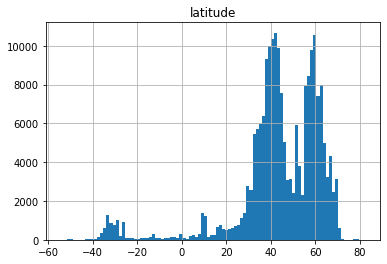

In [8]:
latitude_hist = d.hist(column='latitude', bins=100)

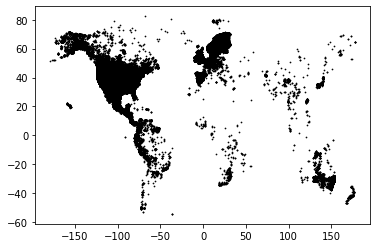

In [9]:
plt.scatter(d.longitude, d.latitude, color='black', s=0.5)

In [10]:
s = d['Species'].to_numpy()
bio10 = d['bio_10'].to_numpy()
bio11 = d['bio_11'].to_numpy()
bio12 = d['bio_12'].to_numpy()
lat   = d['latitude'].to_numpy()
lon   = d['longitude'].to_numpy()
bio_data = list(zip(bio10, bio11, bio12))
loc_data = list(zip(lat, lon))

In [11]:
cur_list = 0
bios = [[]]
locs = [[]]
for i in range(1, s.size):
    if s[i] != s[i-1]:
        cur_list += 1
        bios.append([])
        locs.append([])
    bios[cur_list].append(bio_data[i])
    locs[cur_list].append(loc_data[i])

In [12]:
correlation_max = 0.975
tmp_bios = []
tmp_locs = []
tmp_names = []
names_lst = sorted(names)
for i in range(len(bios)):
    if (names_lst[i] != 'Mazama_americana'): # weird issue with mazama americana
        corr = np.corrcoef(bios[i], rowvar=False)
        if not (len(bios[i]) < 9 or np.abs(corr[0][1]) > correlation_max or np.abs(corr[0][2]) > correlation_max):
            tmp_bios.append(bios[i])
            tmp_locs.append(locs[i])
            tmp_names.append(names_lst[i])

In [13]:
bios = tmp_bios
locs = tmp_locs
names = tmp_names
n = len(bios)

In [14]:
nlat = nubes['Latitude'].to_numpy()
nlon = nubes['Longitude'].to_numpy()

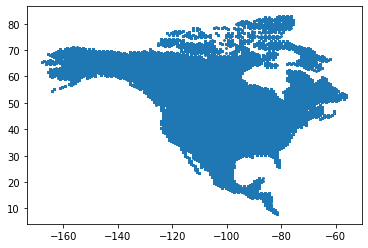

In [15]:
plt.scatter(nlon, nlat, s=1.5)

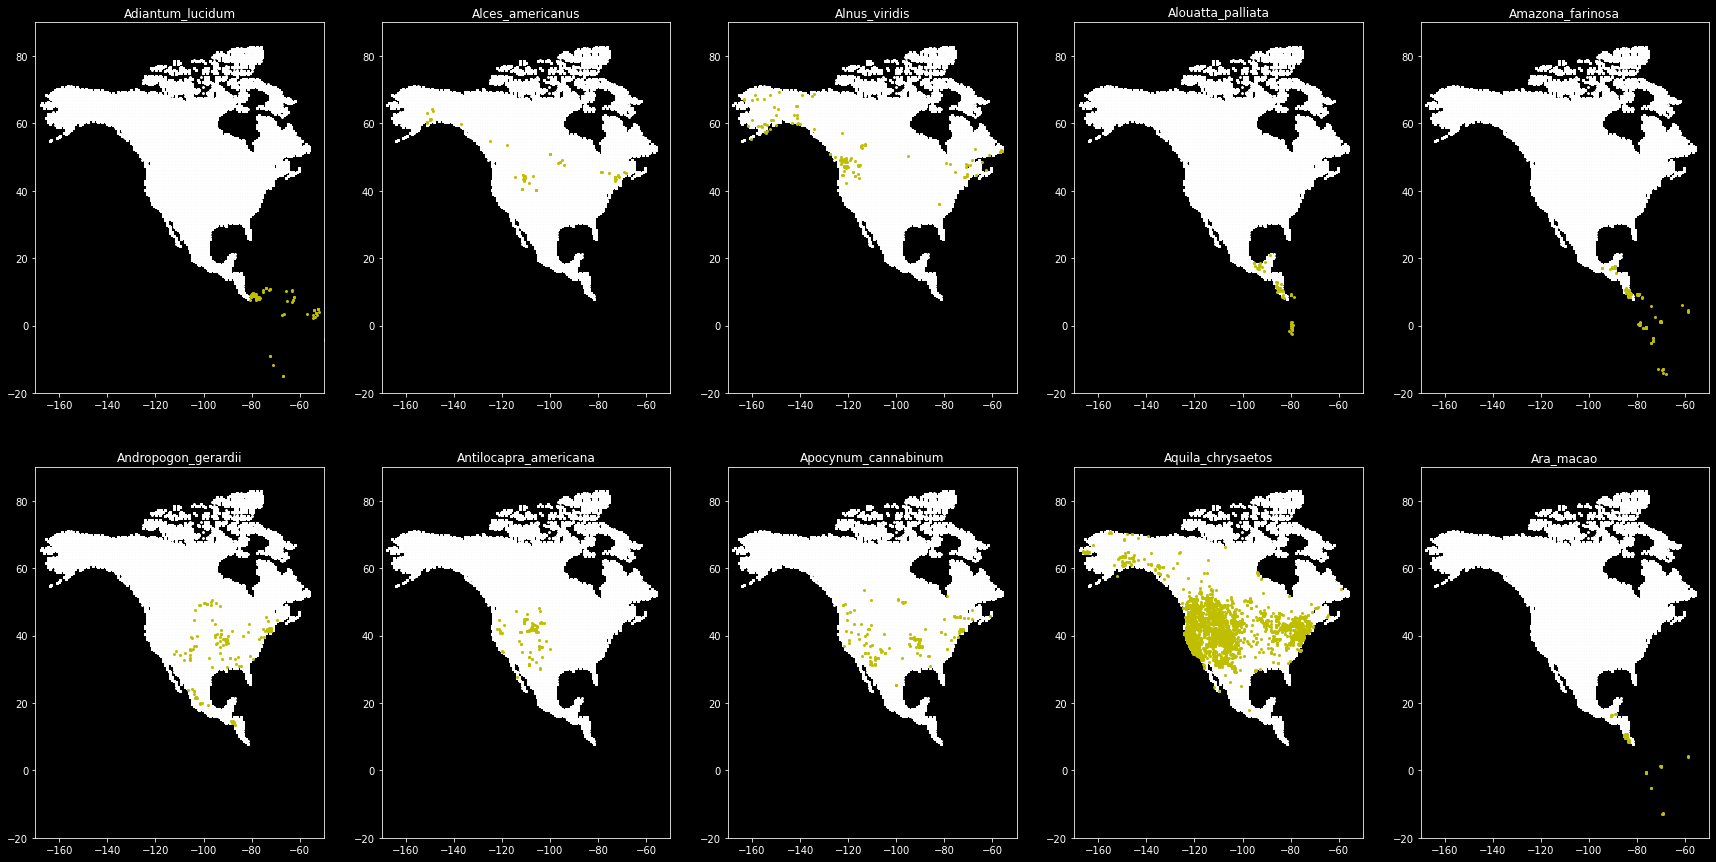

In [18]:
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(30, 15))
plt.style.use(['dark_background'])
for row in range(rows):
    for col in range(cols):
        i = (5 * row) + col
        loc = np.array(locs[i]).T
        axes[row, col].scatter(nlon, nlat, s=1.5, c='white')
        axes[row, col].scatter(loc[1], loc[0], c='y', s=4)
        axes[row, col].set_xlim([-170, -50])
        axes[row, col].set_ylim([-20, 90])
        axes[row, col].set_title(names[i])
        
#plt.savefig('locs.jpg')


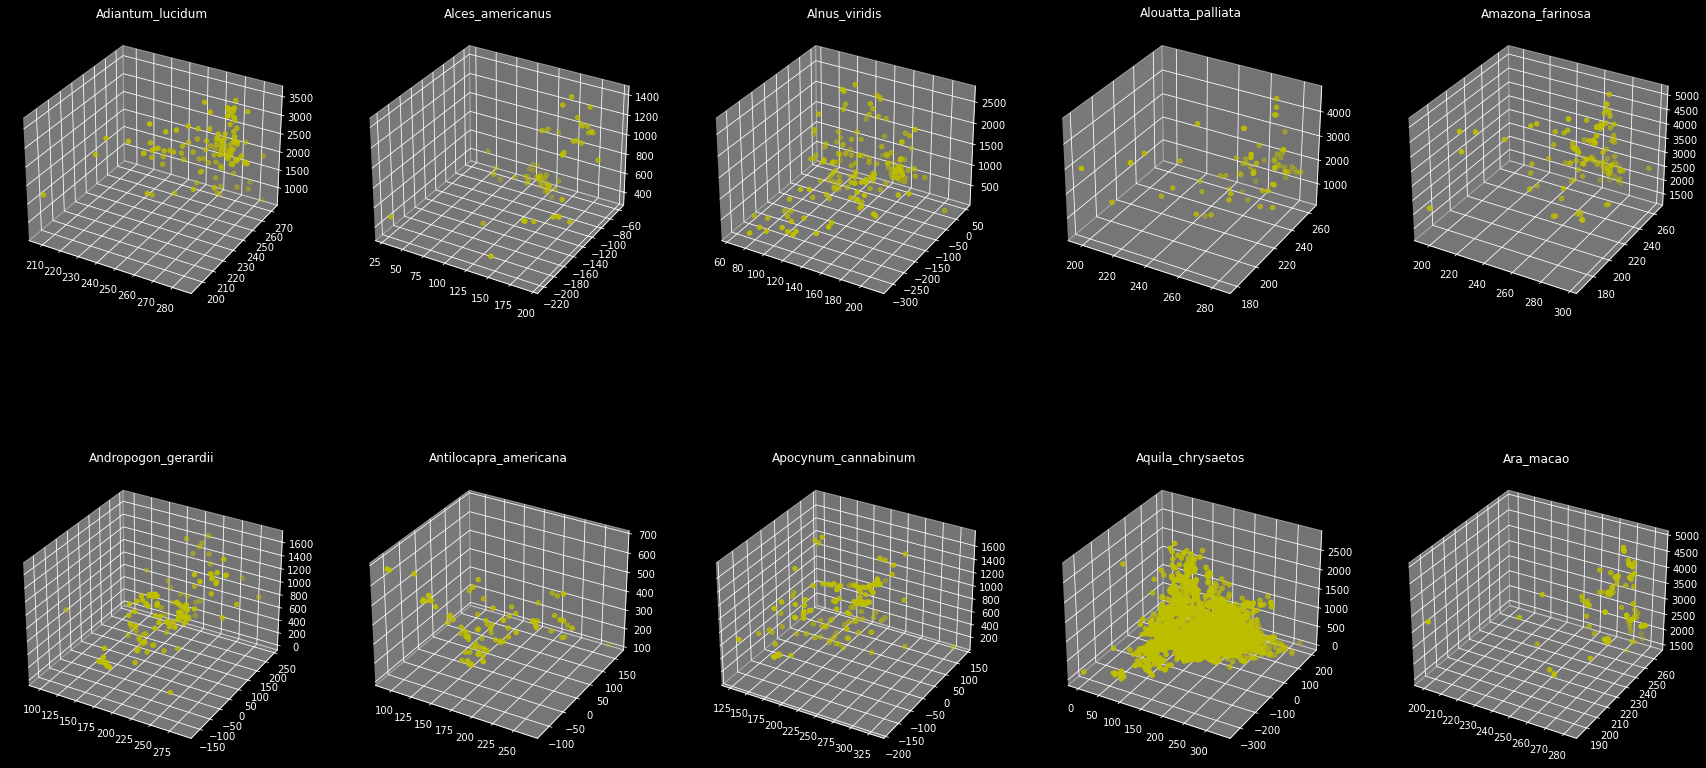

In [19]:
rows, cols = 2, 5
fig = plt.figure(figsize = (30, 15))

plt.style.use(['dark_background'])
for row in range(rows):
    for col in range(cols):
        i = (5 * row) + col
        loc = np.array(locs[i]).T
        bio = np.array(bios[i]).T
        axes = fig.add_subplot(rows, cols, i + 1, projection = '3d')
        axes.scatter3D(bio[0], bio[1], bio[2], c='y')
        axes.set_title(names[i])
        
#plt.savefig('bios.jpg')

In [20]:
#np.array((n,))
v1 = sym.Symbol('v1')
v2 = sym.Symbol('v2')
v3 = sym.Symbol('v3')
v = np.array([v1, v2, v3])

In [21]:
def ellipsoid_quantile(data: np.array, q: float) -> np.array:
    cov = np.cov(data.T)
    inv_cov = np.linalg.inv(cov)
    mean = np.mean(data, axis=0)
    
    _, eig_vects = np.linalg.eig(cov)

    # distances from the mean in the 'circular' space
    circled_data = sorted(np.sqrt([np.dot(np.dot((row-mean).T, inv_cov), (row-mean)) for row in data]))
    n = len(circled_data)
    n_at_distance = Counter(circled_data)

    # calculate qlevel
    qlevel = [0]
    for distance in reversed(sorted(n_at_distance.keys())):
        qlevel.append(qlevel[-1]+n_at_distance[distance])
    qlevel = [(n-float(i))/n for i in qlevel]
    qlevel = qlevel[1:-1]
    qlevel = np.array(qlevel)

    # ========================
    
    index_outer = qlevel[qlevel>q].shape[0]+1
    index_inner = index_outer+1
    
    qlevel = [1] + list(qlevel)
    distances = list(reversed(sorted(set(circled_data))))
    qo = qlevel[index_outer-1]
    do = distances[index_outer-1]

    if index_outer == len(distances):
        qi, di = 0, 0
    else:
        qi = qlevel[index_inner-1]
        di = distances[index_inner-1]

    quantile_distance = di + (do-di)*((q-qi)/(qo-qi))
    quantile_distance = quantile_distance**2

    new_covariance =  quantile_distance * cov

    # ========================

    vals, vects = np.linalg.eig(new_covariance)
    radii = np.sqrt(vals)

    # ========================
    #print(type(eig_vects))
    
    return mean, radii, eig_vects

In [22]:
frmq = []
for i in trange(n):
    eq = ellipsoid_quantile(np.array(bios[i]), 0.9)
    mu = eq[0]
    sigma = eq[2].T @ np.diag(1 / (eq[1]**2)) @ eq[2]
    frmq.append(sym.simplify((v - mu) @ sigma @ (v - mu).T))

  0%|          | 0/182 [00:00<?, ?it/s]

In [23]:
str(frmq[0])

'0.000667655398762175*v1**2 - 6.67831143983452e-5*v1*v2 - 6.6668579844635e-5*v1*v3 - 0.180568233946895*v1 + 0.0109398690208511*v2**2 + 0.0225071371443496*v2*v3 - 58.8447248928166*v2 + 0.0115773202146722*v3**2 - 60.5376419851966*v3 + 79184.8416726542'

In [24]:
set_obj = sym.solveset(str(frmq[0]), v3, sym.S.Reals)

In [25]:
set_obj.args[1]

FiniteSet(0.00287927510893861*v1 - 0.972035701138585*v2 - 63.8680904709024*sqrt(-1.4135592590118e-5*v1**2 + 4.19027354353212e-8*v1*v2 + 0.00751444231095308*v1 - 2.11454615289503e-8*v2**2 - 5.16237570883292e-7*v2 - 1.0) + 2614.49285597525, 0.00287927510893861*v1 - 0.972035701138585*v2 + 63.8680904709024*sqrt(-1.4135592590118e-5*v1**2 + 4.19027354353212e-8*v1*v2 + 0.00751444231095308*v1 - 2.11454615289503e-8*v2**2 - 5.16237570883292e-7*v2 - 1.0) + 2614.49285597525)

In [26]:
ans = set_obj.args[1].subs([(v1, 0), (v2, 0)])
ans

FiniteSet(2614.49285597525 - 63.8680904709024*I, 2614.49285597525 + 63.8680904709024*I)

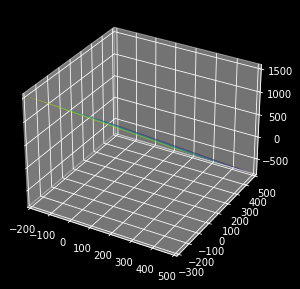

In [27]:
sym.plotting.plot3d(str(set_obj.args[0]), (v1, -200, 500), (v2, -300, 500))

In [65]:
x = sym.Symbol('x', real=True)
y = sym.Symbol('y', real=True)
z = sym.Symbol('z', real=True)
ellipse_equation = sym.Eq((x**2 / 1) + (y**2 / 1) + (z**2 / 1), 1)

In [66]:
solution = sym.solveset(ellipse_equation, z, domain=sym.Reals)

In [67]:
solution

Intersection(FiniteSet(sqrt(-x**2 - y**2 + 1), -sqrt(-x**2 - y**2 + 1)), Reals)

In [68]:
i = 300
j = 300

val = solution.subs({x: i, y:j})

In [79]:
xs = []
ys = []
zs = []
for a in range(-100, 100, 1):
    for b in range(-100, 100, 1):
        i = a / 100
        j = b / 100
        val = solution.subs({x: i, y: j})
        if (type(val) != sym.sets.sets.EmptySet):
            xs.append(i)
            ys.append(j)
            zs.append(val)

In [80]:
type(val) == sym.sets.sets.EmptySet

True

In [82]:
len(xs)

31407

In [83]:
len(ys)

31407

In [84]:
len(zs)

31407

In [85]:
xs[2]

-0.99

In [87]:
ys[2]

-0.13

In [89]:
zs[2]

FiniteSet(-0.0547722557505169, 0.0547722557505169)